### Fraud Test data 

Use only logistic regression.
Data from https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [2]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
'''
data = pd.read_csv('ieee-fraud-detection/train_transaction.csv')
data.shape # (590540, 394)
data.to_pickle('ieee_pickled.pkl')
'''

In [3]:
data = pd.read_pickle('ieee_pickled.pkl')

In [6]:
data.shape # size (590540, 394), last one is label

(590540, 394)

In [68]:
labels = data.iloc[:, 1]
n_positive = sum(labels)
print(n_positive)
print('percent positive = ', n_positive/len(labels))

20663
percent positive =  0.03499000914417313


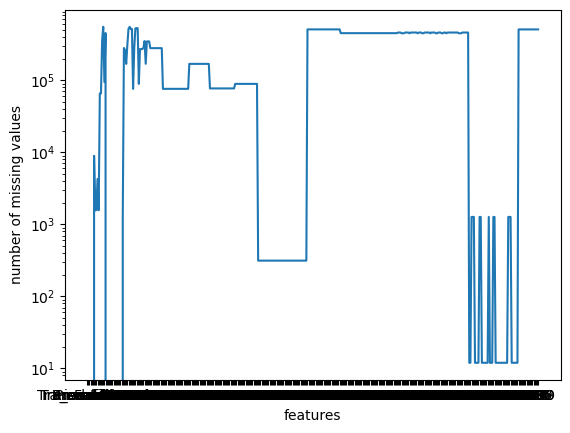

In [5]:
nan_count = data.isna().sum()
plt.plot(nan_count)
plt.yscale('log')
plt.ylabel('number of missing values'), plt.xlabel('features')
plt.show()

In [7]:
good_col = data.columns[nan_count < 100] 
print(len(good_col))

52


there are 19 features with no missing values, 52 features with fewer than 100 missing values, 94 features with fewer than 1000 missing values.<br>
In the case of < 100 missing values, all columns with missing values share the same 12 indices. 2 of these are fraud.<br>
In the case of < 1000 missing values, the missing values lie in 326 different rows. Among these, 19 of them are fraud. This ratio is a bit high.

In [8]:
data_sub = data[good_col]
data_sub.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,...,V309,V310,V311,V312,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,2.0,5.0,0.0,0.0,...,0.0,354.0,0.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
total_missing = []
for col in good_col:
    missing_idx = data_sub.index[data_sub[col].isna()].tolist()
    total_missing.extend(missing_idx)

print('number of rows with missing values', len(set(total_missing)))    
print('fraudulent', sum(data.isFraud[list(set(total_missing))]))

number of rows with missing values 12
fraudulent in these 2


In [28]:
data_sub_nomissing = data_sub.drop(set(total_missing))
data_sub_label = data_sub_nomissing['isFraud']
data_sub_features = data_sub_nomissing.drop(columns=['isFraud'])

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [30]:
 # there are 5 values in ProductCD, W: 439665, C: 68512, R:37699, H: 330024, S: 11628
data_sub_features.ProductCD.value_counts()

ProductCD
W    439665
C     68512
R     37699
H     33024
S     11628
Name: count, dtype: int64

In [33]:
data_sub_encoded = pd.get_dummies(data_sub_features, columns = ['ProductCD'], dtype=int)
data_sub_encoded.head()

,TransactionID,TransactionDT,TransactionAmt,card1,C1,C2,C3,C4,C5,C6,...,V317,V318,V319,V320,V321,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,2987000,86400,68.5,13926,1.0,1.0,0.0,0.0,0.0,1.0,...,117.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,2987001,86401,29.0,2755,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
2,2987002,86469,59.0,4663,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
3,2987003,86499,50.0,18132,2.0,5.0,0.0,0.0,0.0,4.0,...,1404.0,790.0,0.0,0.0,0.0,0,0,0,0,1
4,2987004,86506,50.0,4497,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [47]:
scaler = MinMaxScaler()
data_noid = data_sub_encoded.drop(columns=['TransactionID', 'TransactionDT'])
data_normalized = pd.DataFrame(scaler.fit_transform(data_noid), columns = data_noid.columns)
data_normalized.var()

TransactionAmt    0.000056
card1             0.079379
C1                0.000813
C2                0.000739
C3                0.000034
C4                0.000934
C5                0.005459
C6                0.001007
C7                0.000749
C8                0.000820
C9                0.006304
C10               0.000861
C11               0.000876
C12               0.000739
C13               0.001965
C14               0.001202
V279              0.000571
V280              0.000816
V284              0.000795
V285              0.001194
V286              0.000570
V287              0.001211
V290              0.000136
V291              0.000238
V292              0.000137
V293              0.000561
V294              0.000945
V295              0.000783
V297              0.002742
V298              0.001166
V299              0.001238
V302              0.000907
V303              0.000972
V304              0.001090
V305              0.000007
V306              0.000466
V307              0.000908
V

In [40]:
# numerical columns only 
data_num = data[['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud']].copy()

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X = data_num.iloc[:, 1:-2].copy()
y = data_num.iloc[:, -1].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       stratify = y,
                                                       test_size = .2)

In [42]:
model = LogisticRegression(class_weight='balanced', max_iter =500, penalty=None)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)

In [43]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

In [44]:
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, probs)
print('accuracy', accuracy)
print('log loss', logloss)

accuracy 0.4977956524868639
log loss 0.6902817443311748


In [45]:
conf = confusion_matrix(y_test, y_pred)
print(conf)

[[55104 55611]
 [  206   223]]
